**Strategy of Fitting Ensemble Models:**<br/> 

1) **Data Pre-Processing**: after reading the dataframe, we first split the training/test data by (90%-10% split) due to the small size of the dataset, then standardize the numerical columns before fitting the models, and finally checking for any missing data and impute accordingly. 

2) **Model Score Function**: for the simplicity of model summary, we will create a model scoring function encompassing the following 6 metrics <br/> 
- $R^2$ (R Squared)
- $EVar$ (Explained Variance Score)
- $MAE$ (Mean Absolute Error)
- $MSE$ (Mean Squared Error)
- $MSLE$ (Mean Squared Log Error)
- $MEAE$ (Median Absolute Error)

3) **Model Fitting**: here, we will fit 9 different ensemble regressors on the training data and then predict using the test data
- Gradient Boosting Regressor
- Random Forest Regressor
- Huber Regressor
- Elastic Net
- SVR
- Neural Network
- Adaboost Regressor
- Bagging Regressor
- Extra Trees Regressor

4) **Model Summary**: after fitting all the models, we will present 3 summary tables based on training score, test score and qualitative metrics for the models

5) **Cross Validation**: based on the summary, we will further fine-tune the parameters on the best model by cross validation

In [1]:
# Import Basic Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from operator import itemgetter
from statistics import mode
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from itertools import product
from collections import OrderedDict

In [2]:
# Import Regression Packages
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor,ExtraTreesRegressor,BaggingRegressor
from sklearn.linear_model import LinearRegression,HuberRegressor,ElasticNet,LassoCV,RidgeCV,PassiveAggressiveRegressor,SGDRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error

In [218]:
# Set color and fonts
green_col = np.divide([30,215,96],255)
black_col = [0,0,0]
gray_col = np.divide([150,150,150],255)
light_gray_col = np.divide([236,235,232],255)
white_col =  np.divide([255,255,255],255)
med_gray_col = np.divide([80,80,80],255)

colors = [green_col, black_col, gray_col, light_gray_col, white_col]

afont = {'fontname':'AppleGothic'}
hfont = {'fontname':'Helvetica'}
ifont = {'fontname': 'Impact'}
arfont = {'fontname': 'Arial'}
ofont = {'fontname': 'Osaka'}
sfont = {'fontname': 'STHeiti'}
hirafont = {'fontname': 'Hiragino Kaku Gothic ProN'}

## Section 1. Data Pre-Processing

After reading in the dataframe, we will pre-process the data in four steps: 
- A training/test split is constructed where **90%** of the subsample is the **training** data and **10%** is the **test** data
- Locate the missing columns in the dataframe and proceed with **median-based imputation**
- After imputation, we **standardize** the numerical columns with training mean and standard deviation 
- Lastly, we **log-transform** the response variable 'No. of Followers' to make it more aligned to the Normality assumption

In [3]:
# Read-in the full data set
data = pd.read_csv('data/Final_Dataframe.csv')

In [4]:
# Drop name column
data = data.drop("Unnamed: 0", axis=1)

In [5]:
### Section 1.1 Training/Test Data Split

In [6]:
# A train/test split is constructed where 90% of the subsample is 
# the train data set and 10% the test data set.

# Set train and test sizes
train_size = 0.9
test_size = 1-train_size

# Function to return random train and test sets
def data_splitter(df, train, validate=False, seed=9001):
    
    if validate:
        np.random.seed(seed)
        perm = np.random.permutation(df.index)
        m = len(df)
        train_end = int(train * m)
        validate_end = int(validate * m) + train_end
        train = df.ix[perm[:train_end]]
        validate = df.ix[perm[train_end:validate_end]]
        test = df.ix[perm[validate_end:]]
        return train, validate, test
    else:
        np.random.seed(seed)
        perm = np.random.permutation(df.index)
        m = len(df)
        train_end = int(train * m)
        train = df.ix[perm[:train_end]]
        test = df.ix[perm[train_end:]]
        return train, test

In [7]:
# Create train and test dataframes from subsample
train_df, test_df = data_splitter(data, train_size)

# Return shapes of train and test dataframes
print("Train Size: {}".format(train_df.shape))
print("Test Size: {}".format(test_df.shape))

Train Size: (1278, 949)
Test Size: (142, 949)


In [8]:
### Section 1.2 Imputation

In [9]:
# Find Missing Columns
null_vals = train_df.isnull().sum()
missing_vals = null_vals[null_vals > 0].index.tolist() 
missing_vals

['acousticness_std',
 'dance_std',
 'energy_std',
 'instrumentalness_std',
 'key_std',
 'liveness_std',
 'loudness_std',
 'mode_std',
 'speech_std',
 'tempo_std',
 'time_std',
 'valence_std',
 'followers_std',
 'popularity_std',
 'hip hop_acousticness_std',
 'pop_liveness_std',
 'dance_liveness_std',
 'r&b_acousticness_std',
 'rap_energy_std',
 'rap_key_std',
 'acoustic_acousticness_std',
 'acoustic_energy_std',
 'acoustic_key_std',
 'soul_acousticness_std']

In [10]:
#### Method 1: KNN-Based Imputation

In [11]:
# Import KNN Regression Imputer
# from fancyimpute import KNN

# Use 3 nearest rows to fill missing observations
# train_df[missing_vals] = KNN(k=3).complete(train_df[missing_vals])

# Use 3 nearest rows to fill missing observations
# test_df[missing_vals] = KNN(k=3).complete(test_df[missing_vals])

In [12]:
#### Method 2: Median-Based Imputation

In [13]:
# Median imputation of missing values
imp = Imputer(missing_values='NaN', strategy='median', axis=1)
train_df = pd.DataFrame(imp.fit_transform(train_df), columns=data.columns)
test_df = pd.DataFrame(imp.transform(test_df), columns=data.columns)

In [14]:
# Split training and test data
train_df = train_df[train_df['Followers'] != 0]
test_df = test_df[test_df['Followers'] != 0]

In [15]:
### Section 1.3 Standardization

In [16]:
# List all numerical columns to be used for classification
numerical_columns = ['acousticness_mean','acousticness_std','dance_mean','dance_std',\
                    'energy_mean','energy_std','instrumentalness_mean','instrumentalness_std',\
                    'key_mean','key_std','liveness_mean','liveness_std','loudness_mean',\
                    'loudness_std','mode_mean','mode_std','speech_mean','speech_std',\
                    'tempo_mean','tempo_std','valence_mean','valence_std','followers_mean',\
                    'followers_std','popularity_mean','popularity_std',\
                    'house_acousticness_mean', 'hip hop_acousticness_std','pop_liveness_std', \
                     'dance_liveness_std', 'r&b_acousticness_std','rap_energy_std', 'rap_key_std',\
                     'acoustic_acousticness_std','acoustic_acousticness_mean', 'acoustic_energy_std',\
                     'acoustic_key_std']

In [17]:
# The numerical columns are standardized next
mean = train_df[numerical_columns].mean()
std = train_df[numerical_columns].std()

train_df[numerical_columns] = (train_df[numerical_columns] - mean)/std
test_df[numerical_columns] = (test_df[numerical_columns] - mean)/std

In [18]:
### Section 1.4 Transformation

In [19]:
# Final step: create y_train/x_train and y_test/x_test dataframes

# Initialize the training data
y_train = np.log(train_df['Followers'])
x_train = train_df.drop('Followers', axis=1)

# Initialize the testing data
y_test = np.log(test_df['Followers'])
x_test = test_df.drop('Followers', axis=1)

## Section 2. Model Score Function

Here, we choose 6 metrics to evaluate our models: 

1) **$R^2$ - R Squared** = measures how well future datasets are likely to be predicted by the model. The score ranges from negative (because the model can be arbitrarily worse) to a best possible value of 1.0. Usually, the bigger the $R^2$, the better the model. Yet we do acknowledge the tedency of over-fitting with $R^2$ as with more predictors, it will only remain constant or increase.

$$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=0}^{n-1}(y_i-\hat{y}_i)^2)}{\sum_{i=0}^{n-1}(y_i-\bar{y})^2}, n = \text{sample size}$$


2) **$EVar$ - Explained Variance Score** = measures how good the model explains the variance in the response variable. The score ranges from a minimum of 0 to a maximum of 1.0. Similar to $R^2$, the higher the score, the better the model.

$$EVar(y, \hat{y}) = 1 - \frac{\text{Var}(y - \hat{y})}{\text{Var}(y)}$$


3) **$MAE$ - Mean Absolute Error** = computes the expected value of the absolute error or the $l1$ loss function. For all the error functions, the smaller the error, the better the model.

$$MAE(y, \hat{y}) = \frac{1}{n} \sum_{i=0}^{n-1} |y_i-\hat{y}_i| $$


4) **$MSE$ - Mean Squared Error** = computes the expected value of the squared error

$$MSE(y, \hat{y}) = \frac{1}{n} \sum_{i=0}^{n-1} (y_i-\hat{y}_i)^2 $$


5) **$MSLE$ - Mean Squared Log Error** = computes the expected value of the squared logarithmic error. This would probably be the most appropriate metric to evalute our models as we log-transformed our response variable - number of followers for the playlist. 

$$MSLE(y, \hat{y}) = \frac{1}{n} \sum_{i=0}^{n-1} [\ln(1+y_i)-\ln(1+\hat{y}_i)]^2$$


6) **$MEAE$ - Median Absolute Error** = computes the loss function by using the median of all absolute differences between the actual values and the predicted values. This metric is robust to outliers. 

$$MEAE(y, \hat{y}) = \text{median}(|y_1-\hat{y}_1|, \cdots, |y_n-\hat{y}_n|)$$

The key metrics given the parameters of our pre-processing are 1) $R^2$ and 5) $MSLE$, which will be the most important basis of comparison for the 9 ensemble models.

In [20]:
# Define score for regression model
def expected_score1(model, x, y):
    R2 = 0
    EVar = 0
    MAE = 0
    MSE = 0
    MSLE = 0
    MEAE = 0

    R2 += model.score(x, y)
    EVar += explained_variance_score(y, model.predict(x))
    MAE += mean_absolute_error(y, model.predict(x))
    MSE += mean_squared_error(y, model.predict(x))
    MSLE += mean_squared_log_error(y, model.predict(x))
    MEAE += median_absolute_error(y, model.predict(x))

    return pd.Series([R2 / 100., 
                      EVar / 100., 
                      MAE / 100., 
                      MSE / 100.,
                      MSLE / 100.,
                      MEAE / 100.],
                      index = ['R2', 'EVar', 'MAE', 'MSE', 'MSLE', 'MEAE'])

score = lambda model, x, y: pd.Series([model.score(x, y), 
                                       explained_variance_score(y, model.predict(x)),
                                       mean_absolute_error(y, model.predict(x)),
                                       mean_squared_error(y, model.predict(x)),
                                       mean_squared_log_error(y, model.predict(x)),
                                       median_absolute_error(y, model.predict(x))], 
                                      index=['R2', 'EVar', 'MAE', 'MSE', 'MSLE', 'MEAE'])

## Section 3. Model Fitting

### Section 3.1 Gradient Boosting Regressor

According to Ben Gorman, if Linear Regression were a Toyota Camry, the Gradient Boosting Regressor would easily be a UH-60 Blackhawk Helicopter.

Gradient Boosting Regressor is an ensemble machine learning procedure that fits new models consecutively to provide a more reliable estimate of the response variable. It constructs new base-learners to be correlated with the negative gradient of the loss function: 1) least square regression (ls), 2) least absolute deviation (lad), 3) huber (a combination of ls and lad), 4) quantile - which allows for quantile regression. The choice of the loss function allows for great flexibility in Gradient Boosting and the best error function is huber for our model based on trial and error / cross-validation. 

The principle behind this procedure is to adopt a slow learning approach where we fit a regression tree to the residuals from the model rather than the actual response variable. We then add this new regression tree to update the residuals. The base learner here could be small regression trees and we slowly improve them in areas that they do not perform well. 

The main tuning parameters are the number of splits in each tree ($d$) - which controls the complexity of boosting, the number of trees ($B$) - which can overfit if too big, and the shrinkage parameber ($\lambda$).

A simplified algorithm of boosting is described here (James, Witten, Hastie, and Tibshirani, 2013): 

**Step 1**. Set $\hat{f}(x) = 0$ and $r_i = y_i$ for all $i$ in the training set

**Step 2**. For $b = 1, 2, \cdots, B$, repeat the following steps: 

(a) Fit a regression tree $\hat{f}_b$ with $d$ splits to the training data $(X, r)$

(b) Update $\hat{f}$ by adding in a shrunken version of the new regression tree 
$$\hat{f}(x) \leftarrow \hat{f}(x) + \lambda \hat{f}_b(x)$$

(c) Update the residuals 
$$r_i \leftarrow r_i - \lambda \hat{f}_b(x_i)$$

**Step 3**. We finally output the boosted model
$$\hat{f}(x) = \sum_{b=1}^b \lambda \hat{f}_b(x) $$

In [174]:
# GradientBoostingRegressor
estgb = GradientBoostingRegressor(alpha=0.99, loss='huber', max_depth=5, learning_rate=0.03, 
                                  n_estimators=200, max_features='auto')
estgb.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.99, criterion='friedman_mse', init=None,
             learning_rate=0.03, loss='huber', max_depth=5,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [178]:
estgb_training = score(estgb, x_train, y_train)

In [176]:
estgb_test = score(estgb, x_test, y_test)

In [215]:
features = x_train.columns
importances = estgb.feature_importances_
estgb_feature_df = pd.DataFrame({'features': features, 'importances': importances})
estgb_feature_ranking = estgb_feature_df.sort_values('importances', axis=0, ascending=False).head(10)
print ('Gradient Boosting Feature Importance:')
estgb_feature_ranking

Gradient Boosting Feature Importance:


,features,importances
22,valence_mean,0.045590
2,dance_mean,0.035858
27,popularity_std,0.034743
17,speech_std,0.028664
938,pop_liveness_std,0.028426
14,mode_mean,0.027019
931,Str_2000s,0.026230
23,valence_std,0.026000
10,liveness_mean,0.025671
13,loudness_std,0.024740


In [273]:
sns.set_style('whitegrid')

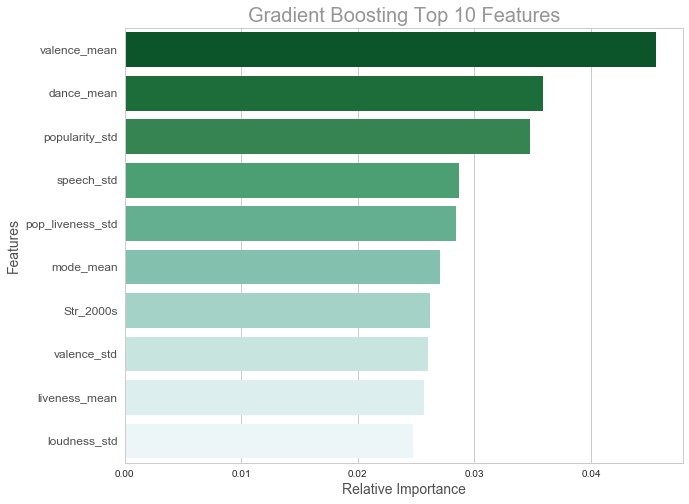

In [271]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
ax = sns.barplot(x='importances', y='features', data=estgb_feature_ranking, palette="BuGn_r")
ax.set_title('Gradient Boosting Top 10 Features', fontsize = 20, color = gray_col)
ax.set_xlabel('Relative Importance', fontsize=14, color=med_gray_col)
ax.set_ylabel('Features', fontsize=14, color=med_gray_col)
ax.set_yticklabels(estgb_feature_ranking['features'], fontsize=12, color=med_gray_col);

### Section 3.2 Random Forest Regressor

Random Forest Regressor is another commonly used machine learning method that incorporates different regression trees. We bootstrap the training samples, which are used to build an ensemble of full regression trees. Each time a split in a tree is considered, we randomly select a subset of predictors (typically set as 'sqrt' which means we take $m = \sqrt{p}$ of the full set of $p$ predictors. Finally, we average the predictors. This is an improvement to bagging (which takes the full set of predictors $m=p$) because by allowing only a random subset of predictors, Random Forest effectively decorrelates the regression trees. 

In comparsion to Boosting where weak learners (high bias, low variance) are used as base learners, which are then modelled sequentially to minimize bias, Random Forest models fully grown decision trees (low bias, high variance) in parallel and aims to reduce variance. In this way, Random Forest effectively limits the chances of over-fitting whereas boosting sometimes does overfit.

In [41]:
# RandomForestRegressor
rfrg = RandomForestRegressor(n_estimators=200, max_depth=15, max_features='auto', min_samples_leaf=2, random_state=2)
rfrg.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [42]:
rfrg_training = score(rfrg, x_train, y_train)

In [43]:
rfrg_test = score(rfrg, x_test, y_test)

In [214]:
features = x_train.columns
importances = rfrg.feature_importances_
rfrg_feature_df = pd.DataFrame({'features': features, 'importances': importances})
rfrg_feature_ranking = rfrg_feature_df.sort_values('importances', axis=0, ascending=False).head(10)
print ('Random Forest Feature Importance:')
rfrg_feature_ranking

Random Forest Feature Importance:


,features,importances
22,valence_mean,0.063908
931,Str_2000s,0.043435
2,dance_mean,0.034744
10,liveness_mean,0.032225
17,speech_std,0.029070
27,popularity_std,0.026800
1,acousticness_std,0.022987
26,popularity_mean,0.021267
23,valence_std,0.020011
18,tempo_mean,0.019738


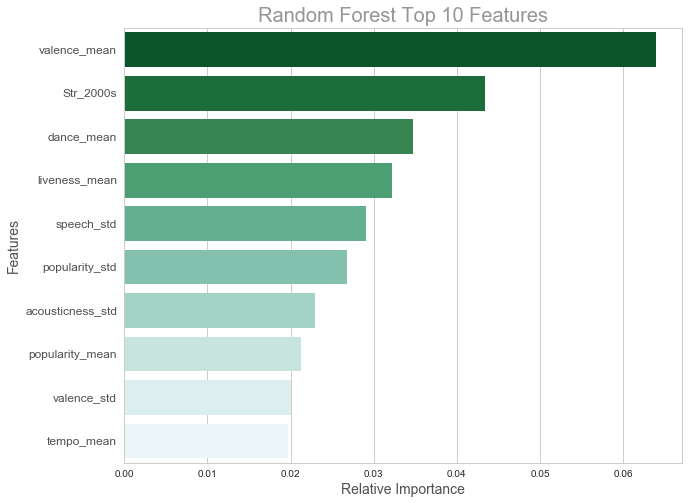

In [263]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
ax = sns.barplot(x='importances', y='features', data=rfrg_feature_ranking, palette="BuGn_r")
ax.set_title('Random Forest Top 10 Features', fontsize = 20, color = gray_col)
ax.set_xlabel('Relative Importance', fontsize=14, color=med_gray_col)
ax.set_ylabel('Features', fontsize=14, color=med_gray_col)
ax.set_yticklabels(rfrg_feature_ranking['features'], fontsize=12, color=med_gray_col);

### Section 3.3 Huber Regressor

In [44]:
# HuberRegressor
hubrg = HuberRegressor(max_iter=100, epsilon=1.0, alpha=10000)
hubrg.fit(x_train, y_train)

HuberRegressor(alpha=10000, epsilon=1.0, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

In [45]:
hubrg_training = score(hubrg, x_train, y_train)

In [46]:
hubrg_test = score(hubrg, x_test, y_test)

### Section 3.4 Elastic Net

In [47]:
# ElasticNet
elarg = ElasticNet(max_iter=1000, alpha=0.05, l1_ratio=1.0)
elarg.fit(x_train, y_train)

ElasticNet(alpha=0.05, copy_X=True, fit_intercept=True, l1_ratio=1.0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [48]:
elarg_training = score(elarg, x_train, y_train)

In [49]:
elarg_test = score(elarg, x_test, y_test)

### Section 3.5 SVR

In [50]:
# SVR
svrrg = SVR(kernel='rbf', C=10.0, epsilon=2.0)
svrrg.fit(x_train, y_train)

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=2.0, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [51]:
svrrg_training = score(svrrg, x_train, y_train)

In [52]:
svrrg_test = score(svrrg, x_test, y_test)

### Section 3.6 Neural Network

In [53]:
# Neural Network
mlprg = MLPRegressor(alpha=0.000001)
mlprg.fit(x_train, y_train)

MLPRegressor(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [54]:
mlprg_training = score(mlprg, x_train, y_train)

In [55]:
mlprg_test = score(mlprg, x_test, y_test)

### Section 3.7 Adaboost Regressor

In [56]:
# Base Estimator
estgb_small = GradientBoostingRegressor(alpha=0.95, loss='huber', max_depth=3, learning_rate=0.01, 
                                        n_estimators=200, max_features='auto')

In [57]:
# Adaboost Regressor
adarg = AdaBoostRegressor(base_estimator=estgb_small, loss='exponential', learning_rate=0.04, n_estimators=200)
adarg.fit(x_train, y_train)

AdaBoostRegressor(base_estimator=GradientBoostingRegressor(alpha=0.95, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='huber', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
         learning_rate=0.04, loss='exponential', n_estimators=200,
         random_state=None)

In [58]:
adarg_training = score(adarg, x_train, y_train)

In [59]:
adarg_test = score(adarg, x_test, y_test)

In [267]:
features = x_train.columns
importances = adarg.feature_importances_
adarg_feature_df = pd.DataFrame({'features': features, 'importances': importances})
adarg_feature_ranking = adarg_feature_df.sort_values('importances', axis=0, ascending=False).head(10)
print ('Adaboost Regressor Feature Importance:')
adarg_feature_ranking

Adaboost Regressor Feature Importance:


,features,importances
22,valence_mean,0.076019
931,Str_2000s,0.073634
17,speech_std,0.043155
10,liveness_mean,0.041347
930,Str_Acoustic,0.034172
2,dance_mean,0.032189
27,popularity_std,0.030544
1,acousticness_std,0.029788
26,popularity_mean,0.029047
13,loudness_std,0.021482


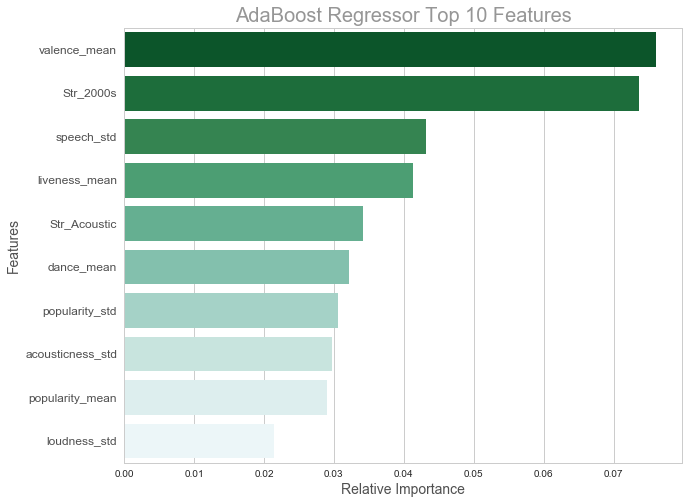

In [269]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
ax = sns.barplot(x='importances', y='features', data=adarg_feature_ranking, palette="BuGn_r")
ax.set_title('AdaBoost Regressor Top 10 Features', fontsize = 20, color = gray_col)
ax.set_xlabel('Relative Importance', fontsize=14, color=med_gray_col)
ax.set_ylabel('Features', fontsize=14, color=med_gray_col)
ax.set_yticklabels(adarg_feature_ranking['features'], fontsize=12, color=med_gray_col);

### Section 3.8 Bagging Regressor

In [60]:
# Base Estimator
bagrg = BaggingRegressor(base_estimator=estgb_small, n_estimators=10, max_samples=1.0, max_features=1.0)
bagrg.fit(x_train, y_train)

BaggingRegressor(base_estimator=GradientBoostingRegressor(alpha=0.95, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='huber', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [61]:
# Bagging Regressor
bagrg_training = score(bagrg, x_train, y_train)

In [62]:
bagrg_test = score(bagrg, x_test, y_test)

### Section 3.9 Extra Trees Regressor

In [63]:
# Extra Trees Estimator
etreerg = ExtraTreesRegressor(n_estimators=100, criterion='mse', max_depth=15, max_features='auto')
etreerg.fit(x_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=15,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [64]:
etreerg_training = score(etreerg, x_train, y_train)

In [65]:
etreerg_test = score(etreerg, x_test, y_test)

## Section 4. Model Summary

### Section 4.1 Training Data

**Insights**
- Based on the training data summary, **9.Extra Trees Regressor** best explains training data, followed by **2. Random Forest Regressor**, and **1. Gradient Boosting Regressor**
- However, we need to bear in mind that too-good a fit on the training data suggests over-fitting - that is, the model has high variance and does not generalize the trends well (because fitted too well to the noise). This is unsurprising as just like classification trees, regression trees have the tendency to over-fit
- We could also easily eliminate **3. Huber Regressor**, **6. Neural Network** because of their terrible performance on the training data and they might not be a good fit for the Spotify data

In [179]:
# Training Summary (Absolute Scores)
training_scores = pd.DataFrame({'1. Gradient Boosting': estgb_training,
                                '2. Random Forest': rfrg_training,
                                '3. Huber': hubrg_training,
                                '4. Elastic Net': elarg_training,
                                '5. SVR': svrrg_training,
                                '6. Neural Network': mlprg_training, 
                                '7. Adaboost': adarg_training,
                                '8. Bagging': bagrg_training,
                                '9. Extra Trees': etreerg_training})
print ('Training Scores:')
training_scores

Training Scores:


,1. Gradient Boosting,2. Random Forest,3. Huber,4. Elastic Net,5. SVR,6. Neural Network,7. Adaboost,8. Bagging,9. Extra Trees
R2,0.736802,0.849933,-10.140200,0.235608,0.316403,-1.250388,0.334077,0.248881,0.919044
EVar,0.736812,0.849968,-0.366807,0.235608,0.318354,-0.782976,0.339111,0.251695,0.919044
MAE,1.216138,0.924503,9.558437,2.126171,2.015300,3.631153,2.067943,2.119796,0.611329
MSE,2.406400,1.372049,101.854169,6.988793,6.250089,20.575162,6.088492,6.867435,0.740172
MSLE,0.034869,0.025533,5.343244,0.094997,0.090284,0.346028,0.082981,0.097215,0.007881
MEAE,0.993349,0.778746,10.386407,1.803829,1.988947,3.070110,1.918677,1.819704,0.433278


In [180]:
# Training Summary (Ranking)
a = training_scores[0:2].rank(1, ascending=False, method='first').reset_index()
b = training_scores[2:6].rank(1, ascending=True, method='first').reset_index()
training_ranking = a.merge(b, how = 'outer').set_index('index')
training_ranking.index.names = ['']
print ('Training Scores Ranking:')
training_ranking

Training Scores Ranking:


,1. Gradient Boosting,2. Random Forest,3. Huber,4. Elastic Net,5. SVR,6. Neural Network,7. Adaboost,8. Bagging,9. Extra Trees
,,,,,,,,,
R2,3.0,2.0,9.0,7.0,5.0,8.0,4.0,6.0,1.0
EVar,3.0,2.0,8.0,7.0,5.0,9.0,4.0,6.0,1.0
MAE,3.0,2.0,9.0,7.0,4.0,8.0,5.0,6.0,1.0
MSE,3.0,2.0,9.0,7.0,5.0,8.0,4.0,6.0,1.0
MSLE,3.0,2.0,9.0,6.0,5.0,8.0,4.0,7.0,1.0
MEAE,3.0,2.0,9.0,4.0,7.0,8.0,6.0,5.0,1.0


### Section 4.2 Test Data

**Insights**
- In terms of the test data, the top 3 performers are **1. Gradient Boosting Regressor**, **2. Random Forest Regressor**, and **7. Adaboost Regressor** if we focus on $R^2$ and $MSLE$

- The parameters in the aforementioned top 2 ensemble methods (as both are over 0.30 for $R^2$, leading the Adaboost Regressor by a margin) could be further fine-tuned to enhance their performance in the cross-validation section

- Our results closely resemble the empirical results by Rich Caruana and Alexandru Niculescu-Mizil's analysis in ***An Empirical Comparison of Supervised Learning Algorithms Using Different Performance Metrics (2005)*** which concluded that boosted trees were the best learning algorithm, closely followed by Random Forest

- While we do note that **1. Gradient Boosting Regressor** has a superior performance by 3% absolute points higher than **2. Random Forest Regressor**, we also need to acknowledge the apparent advantages of using the **2. Random Forest Regressor** as it naturally handles categorical predictor variables, it is relatively quick to fit even for larger datasets, we don't have to assume anything about the underlying population distribution, it fits non-linear interactions well, it also selects variables automatically. And most importantly, Random Forest has only one hyper-parameter that we need to set - the number of features to select at each node, compared to Gradient Boosting which has several hyperparameters that we need to fine-tune in cross-validation. 

In [181]:
# Test Summary (Absolute Scores)
test_scores = pd.DataFrame({'1. Gradient Boosting': estgb_test,
                            '2. Random Forest': rfrg_test,
                            '3. Huber': hubrg_test,
                            '4. Elastic Net': elarg_test,
                            '5. SVR': svrrg_test,
                            '6. Neural Network': mlprg_test, 
                            '7. Adaboost': adarg_test,
                            '8. Bagging': bagrg_test,
                            '9. Extra Trees': etreerg_test})
print ('Test Scores:')
test_scores

Test Scores:


,1. Gradient Boosting,2. Random Forest,3. Huber,4. Elastic Net,5. SVR,6. Neural Network,7. Adaboost,8. Bagging,9. Extra Trees
R2,0.364040,0.335447,-10.592332,0.252289,0.148519,-1.922166,0.251908,0.216170,0.115049
EVar,0.364041,0.336090,-0.096876,0.254182,0.151558,-1.353871,0.253246,0.225546,0.115100
MAE,1.868775,1.906521,9.485701,2.021368,2.135076,4.055117,2.065463,2.024350,2.136890
MSE,5.440345,5.684945,99.167105,6.396325,7.284031,24.997796,6.399582,6.705308,7.570352
MSLE,0.076427,0.085219,5.374158,0.097137,0.110722,0.457958,0.094543,0.102952,0.102324
MEAE,1.595252,1.588612,9.923143,1.710858,1.880958,3.540511,1.928455,1.713208,1.593460


In [182]:
# Test Summary (Ranking)
a = test_scores[0:2].rank(1, ascending=False, method='first').reset_index()
b = test_scores[2:6].rank(1, ascending=True, method='first').reset_index()
test_ranking = a.merge(b, how = 'outer').set_index('index')
test_ranking.index.names = ['']
print ('Test Scores Ranking:')
test_ranking

Test Scores Ranking:


,1. Gradient Boosting,2. Random Forest,3. Huber,4. Elastic Net,5. SVR,6. Neural Network,7. Adaboost,8. Bagging,9. Extra Trees
,,,,,,,,,
R2,1.0,2.0,9.0,3.0,6.0,8.0,4.0,5.0,7.0
EVar,1.0,2.0,8.0,3.0,6.0,9.0,4.0,5.0,7.0
MAE,1.0,2.0,9.0,3.0,6.0,8.0,5.0,4.0,7.0
MSE,1.0,2.0,9.0,3.0,6.0,8.0,4.0,5.0,7.0
MSLE,1.0,2.0,9.0,4.0,7.0,8.0,3.0,6.0,5.0
MEAE,3.0,1.0,9.0,4.0,6.0,8.0,7.0,5.0,2.0


In [ ]:
# Test Summary (Qualitative Metrics)

## Section 5. Cross Validation

In the last section we will assess the accuracy (bias) and precision (residual error) of the **1. Gradient Boosting Regressor** and the **2. Random Forest Regressor**. The idea of cross validation is that we divide our training dataset into 5 random parts, the training set (4 parts) is used to estimate the model, the validation set (1 part) is used to check the predictive capability and refine the model. The test set is only used once to estimate the model's true error. In this way, we can fine-tune our ensemble models' parameters to ensure a more statistically robust model. 

In [183]:
grid = {'max_depth': [5, 10],
        'learning_rate': [0.03, 0.07, 0.10], 
        'n_estimators': [50, 100, 200], 
        'loss': ['ls', 'huber'],
        'alpha': [0.7, 0.9, 0.99], 
        'max_features': ['sqrt', 'auto', 'log2']}

In [184]:
# Create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=grid, n_jobs=-1, cv=5)
clf.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 10], 'learning_rate': [0.03, 0.07, 0.1], 'n_estimators': [50, 100, 200], 'loss': ['ls', 'huber'], 'alpha': [0.7, 0.9, 0.99], 'max_features': ['sqrt', 'auto', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [185]:
clf_test = score(clf, x_test, y_test)
clf_test

R2      0.363502
EVar    0.363517
MAE     1.871419
MSE     5.444946
MSLE    0.076121
MEAE    1.605702
dtype: float64

In [186]:
print ("Best Estimator Parameters")
print ("loss:", clf.best_estimator_.loss)
print ("max_depth: %d" %clf.best_estimator_.max_depth)
print ("n_estimators: %d" %clf.best_estimator_.n_estimators)
print ("learning rate: %.1f" %clf.best_estimator_.learning_rate)
print ("alpha: %.1f" %clf.best_estimator_.alpha)
print ("max_features:", clf.best_estimator_.max_features)
# print ("min_samples_leaf:", clf.best_estimator_.min_samples_leaf)

Best Estimator Parameters
loss: huber
max_depth: 5
n_estimators: 200
learning rate: 0.0
alpha: 1.0
max_features: auto


In [187]:
def plot_learning_curve(estimator, title, X, y, cv=None, train_sizes=np.linspace(.1, 1, 5)):

    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.xlabel("Training Samples")
    plt.ylabel("Error")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    
    train_scores_mean = 1-np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = 1-np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Error")

    plt.legend(loc="best")
    
    return plt.show()

In [ ]:
# Plot results and format using Matplotlib
plot_learning_curve(clf, "Gradient Boosting Regressor Learning Curve", x_train, y_train, cv=5)